# Classification of lymph node histology images using transfer learning in Pytorch

This notebook gives an example of a CNN binary classification of images implemented in PyTorch. It shows how a typical **full image analysis, model training, evaluation, and testing** can be performed with the use of JupyterLab on the DNAnexus platform. The notebook can also be run locally given a GPU card is available.

The problem we're attempting to solve is to create a model to identify metastatic tissue in histopathologic scans of lymph node sections, which is the aim of a Kaggle playground competition [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection), and from which the data comes from.

We're using transfer learning with a [torchvision](https://pytorch.org/docs/stable/torchvision/models.html) model pretrained on the 1000-class Imagenet dataset. We combined **feature extraction** with **fine-tuning** (as explained below) to modify the model so that only a few top hidden layers were retrained, while the weights of the remaining bottom layers were frozen, i.e. the pre-trained weights were used. A custom, fully connected layer with a 2-class output classifier was added at the top.

We'll use **data augmentation** at training. We'll use accuracy and AUROC (area over ROC curve) to evaluate the model. For predictions we'll add **test-time augmentation**.

We'll go through a pipeline divided into these main steps:

[1. Install dependencies and setup the environment](#1.-Install-dependencies-and-setup-environment)  
[2. Download data from the project to the worker](#2.-Download-data-from-the-project-to-the-worker)  
[3. Inspect and preprocess input data](#3.-Inspect-and-preprocess-input-data)  
[4. Prepare input for training](#4.-Prepare-input-for-training)   
[5. Setup training](#5.-Setup-training)   
[6. Train and evaluate](#6.-Train-and-evaluate)  
[7. Test](#7.-Test)  
[8. Upload results to the project](#8.-Upload-results-to-the-project)  


## 1. Install dependencies and setup environment

Some of the most popular tools we'll need (pandas, seaborn, matplotlib, etc.) are already preinstalled in each JupyterLab instance on DNAnexus. A couple additional packages have to be installed. Making the installation a part of the notebook makes it easier to reproduce the runs later.

In [1]:
%%bash
pip install -q torch > /dev/null 2>&1
pip install -q torchvision > /dev/null 2>&1
pip install -q scikit-learn > /dev/null 2>&1
apt-get install unzip > /dev/null 2>&1

In [1]:
import copy
import datetime
import glob
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn import svm, datasets
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

We'll set some of the variables up front, especially those that make the notebook more readable and those that we want to experiment with and change frequently when tuning our model. They include the size of images we want to feed into the model, which depends on the used model. We will use 90% of the input data for training and the remainder will be divided equally into validation and test sets. Our notebook will work with either resnet50 or inception models.

In [2]:
BATCH_SIZE = 256
TRAINING_SIZE=0.9

# For first runs we only use a subset of the data
SUBSET_SIZE = 0.3

# Set model type
MODEL_NAME = "resnet50"
if MODEL_NAME == "inception":
    MODEL_PRETRAINED = models.inception_v3(pretrained=True)
    MODEL_FOR_PREDS = models.inception_v3()
elif MODEL_NAME == "resnet50":
    MODEL_PRETRAINED = models.resnet50(pretrained=True)
    MODEL_FOR_PREDS = models.resnet50()
else:
    print("Model {} not supported".format(MODEL_NAME))

# Resize image size to match input dimensions of the used CNN
INPUT_SIZE = 96
if MODEL_NAME == 'inception':
    INPUT_SIZE = 299

# Specify if the training should be continued from a previously saved checkpoint
RESUME_TRAINING = False
RESUME_TRAINING_PATH = 'histopathology_resnet50_subset100pct_2019-04-29-14-17-57.pth'

# Set timestamp and a path at which we'll save the model checkpoint while training
TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
CHECKPOINT_PATH = "histopathology_{model}_subset{subset}pct_{ts}.pth".format(
    model=MODEL_NAME,
    subset=int(SUBSET_SIZE * 100),
    ts=TIMESTAMP)

# How many subprocesses to use for data loading. 0 means
# the data will be loaded in the main process
NUM_WORKERS=0

NUM_CLASSES = 2
TRAIN_LABELS = 'train_labels.csv'
TRAIN_PATH = 'normalized_train/'

## 2. Download data from the project to the worker

The data (files `train.zip` and `train_labels.csv`) was downloaded from [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data) and stored in a DNAnexus project. It was separately preprocessed (normalized) outside of this notebook, as we explain below.

The input data for the notebook must be available locally, where the notebook is running, so we'll `dx download` the data from a DNAnexus project to the local execution environment. If you are running the notebook on your local computer, make sure you are logged into the DNAnexus platform before running this cell or download the Kaggle data directly to your machine.

In [10]:
%%bash

dx download /data/train_labels.csv

dx download /data/normalized_data/normalized_train.tar.gz
tar -zxvf normalized_train.tar.gz > /dev/null

dx download /data/original_kaggle_data/train_raw_sample.tar.gz
tar -zxvf train_raw_sample.tar.gz > /dev/null

## 3. Inspect and preprocess input data

#### Load labels

In [3]:
labels = pd.read_csv(TRAIN_LABELS, header=0, dtype={'id': str, 'label': np.int32})
labels_dict = dict(zip(list(labels.id), list(labels.label)))
print("Number of samples: {}".format(len(labels)))

Number of samples: 220025


#### Distribution of labels

The training data is labelled with 0 or 1. A positive label indicates that the center 32x32px region of a patch contains tumor tissue.

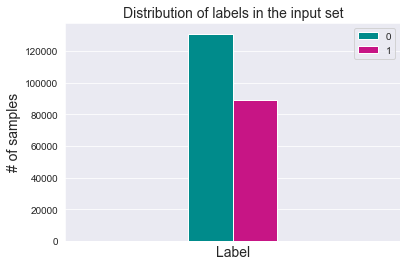

In [4]:
plt.hist([labels[labels.label == 0].label.values, labels[labels.label == 1].label.values],
         color=['darkcyan', 'mediumvioletred'], bins=1)
plt.title('Distribution of labels in the input set', fontdict = {'fontsize': 14})
plt.xlabel('Label', fontdict = {'fontsize': 14})
plt.ylabel('# of samples', fontdict = {'fontsize': 14})
plt.xticks(range(-1, 3))
plt.xticks([], [])
plt.legend(['0', '1'])
plt.show()

#### Visualize raw train data

In order to unearth anomalies or bias in dataset we should visualize some samples of the raw train images (stored in `train_raw_sample.tar.gz` before normalization). For example, this small sample shows that the microscopy images have different color or luminosity due to different tissue staining or microscopy image taking techniques. We therefore ran them separately through a stain normalization tool [StainTools](https://github.com/Peter554/StainTools).

Using train normalization requires that this tool will also available during prediction run on new data. If not available, this type of normalization can be skipped and replaced by, for example, more meticulous data augmentation.

A sample of images with label 0 (no tumor)


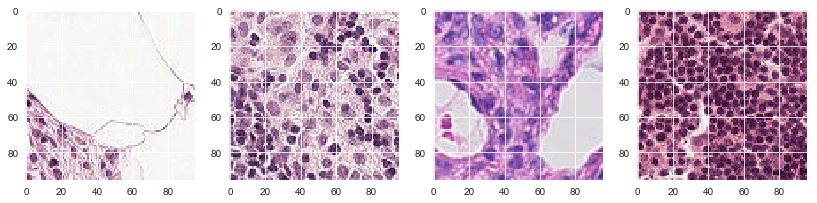

A sample of images with label 1 (tumor detected)


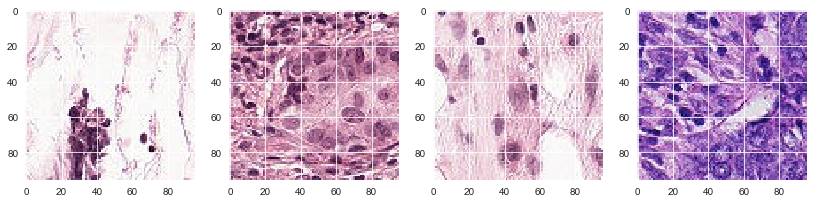

In [5]:
def show_images(sample, directory_n):
    plt.figure(figsize=(14,14))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(Image.open(directory_n + sample.iat[i, 0] + '.tif'))
    plt.show()

print("A sample of images with label 0 (no tumor)")
show_images(labels.loc[labels['label'] == 0], 'train_raw_sample/')
print("A sample of images with label 1 (tumor detected)")
show_images(labels.loc[labels['label'] == 1], 'train_raw_sample/')

#### Data after stain-normalization

A sample of images with label 0 (no tumor)


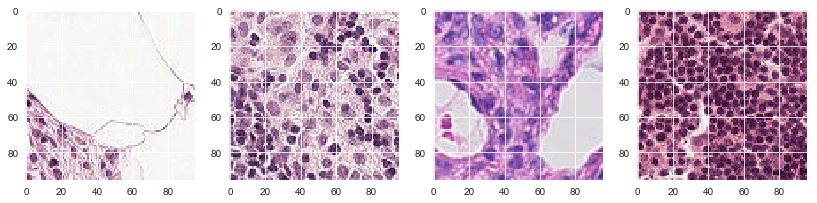

A sample of images with label 1 (tumor detected)


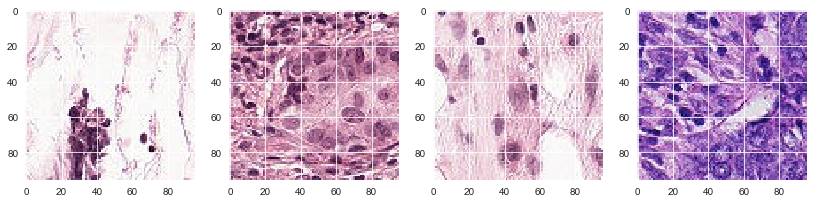

In [6]:
print("A sample of images with label 0 (no tumor)")
show_images(labels.loc[labels['label'] == 0], TRAIN_PATH)
print("A sample of images with label 1 (tumor detected)")
show_images(labels.loc[labels['label'] == 1], TRAIN_PATH)

It is a good idea to inspect the input data further, remove duplicates, slice and "zoom-in" on particular areas of the images, and generally incorporate any domain knowledge we have about the data. In this set we found a few dozen images which are in fact "empty" images, i.e. without any tissue, which was a likely an artifact generated when preparing the data.

## 4. Prepare input for training

### Split input into training, validation, test set
We will split the input into three sets: training, validation, test. Even though the class distribution imbalance in the input is not high, we'll use [stratification](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to make sure the representation of labels is similar in each set.

In [7]:
class DataSplit():
    """
    A class for splitting data into three sets: train, validations, test.
    The training set size can be passed to split(), validation and test
    sets will be divided equally from the remaining set.
    
    Example:
    split = DataSplit(X, y, labels)
    split.split(training_size=0.9)
    split.print_splits(all_train_labels_df)
    split.create_path_sets(train_directory_path)
    """
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.y_train = [], []
        self.X_val, self.y_val  = [], []
        self.X_test, self.y_test = [], []

    def split(self, training_size=0.8):
        random_state = np.random.RandomState(seed=42)

        # 1. Divide the full set into training and the rest
        sss_train_and_rest = StratifiedShuffleSplit(n_splits=1,
                                                    test_size=1-training_size,
                                                    random_state=random_state)
        for train_index, rest_index in sss_train_and_rest.split(self.X, self.y):
            self.X_train, X_rest = X[train_index], X[rest_index]
            self.y_train, y_rest = y[train_index], y[rest_index]

        # 2. Divide the rest equally into validation and test set
        sss_test_and_val = StratifiedShuffleSplit(n_splits=1,
                                                  test_size=0.5,
                                                  random_state=random_state)
        for val_index, test_index in sss_test_and_val.split(X_rest, y_rest):
            self.X_val, self.X_test = X_rest[val_index], X_rest[test_index]
            self.y_val, self.y_test = y_rest[val_index], y_rest[test_index]

        self.assert_no_intersections()

    def assert_no_intersections(self):
        X_train_set = set(self.X_train)
        X_val_set = set(self.X_val)
        X_test_set = set(self.X_test)
        assert(X_train_set.isdisjoint(X_val_set))
        assert(X_train_set.isdisjoint(X_test_set))
        assert(X_val_set.isdisjoint(X_test_set))
    
    def create_path_sets(self, train_dir_path):
        # Get lists of paths to inputs
        self.X_train_paths = np.array([train_dir_path + i + ".tif" for i in self.X_train])
        self.X_val_paths = np.array([train_dir_path + i + ".tif" for i in self.X_val])
        self.X_test_paths = np.array([train_dir_path + i + ".tif" for i in self.X_test])

    def get_class_distr(self, subset):
        return np.sum(subset)/len(subset)

    def print_splits(self, train_labels_df):
        """
        Check that the class distribution (for class num = 2) is roughly the same
        across subsets.
        """
        msg_template = "We'll use {}% ({}) of the full sample size ({})"
        print(msg_template.format(int(SUBSET_SIZE * 100),
                                  int(len(train_labels_df) * SUBSET_SIZE),
                                  int(len(train_labels_df))))

        print()
        print("Set    | Size   | Class distribution")
        print("------------------------------------")
        print("Full   | {:6} | {:.2f}".format(
            len(train_labels_df.label), self.get_class_distr(train_labels_df.label)))
        print("Used   | {:6} | {:.2f}".format(
            len(self.y), self.get_class_distr(self.y)))
        print("Train  | {:6} | {:.2f}".format(
            len(self.y_train), self.get_class_distr(self.y_train)))
        print("Val    | {:6} | {:.2f}".format(
            len(self.y_val), self.get_class_distr(self.y_val)))
        print("Test   | {:6} | {:.2f}".format(
            len(self.y_test), self.get_class_distr(self.y_test)))

In [8]:
train_labels_df = pd.read_csv(TRAIN_LABELS)
train_labels_subset_df = train_labels_df[:int(len(train_labels_df)*SUBSET_SIZE)]

X = train_labels_subset_df.id.values
y = train_labels_subset_df.label.values

split = DataSplit(X, y)
split.split(training_size=TRAINING_SIZE)
split.create_path_sets(TRAIN_PATH)
split.print_splits(train_labels_df)

We'll use 30% (66007) of the full sample size (220025)

Set    | Size   | Class distribution
------------------------------------
Full   | 220025 | 0.41
Used   |  66007 | 0.40
Train  |  59406 | 0.40
Val    |   3300 | 0.40
Test   |   3301 | 0.40


### Define input transforms and augmentation

We're using [torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) to define the type of image transformations we want to perform. We'll resize the images to match the input dimensions required by the chosen pre-trained model and normalize the input using the normalization values the model was trained on.  We'll also convert the images to custom PyTorch [Tensors](https://pytorch.org/docs/stable/tensors.html), which can run on GPUs.

Aditionally, we'll add augmentation by randomly transforming some of the input images during training, e.g. to avoid orientation bias we'll rotate some of the images. Note that these operations don't add new samples to the set but randomly replace our input images.

In [9]:
normalization_mean_std = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

data_transforms = {
    'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomChoice([
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((90, 90)),
                ]),
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((270, 270)),
                ]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
                ]),
            transforms.RandomChoice([
                transforms.ColorJitter(brightness=0.4),
                transforms.ColorJitter(contrast=0.4), 
                transforms.ColorJitter(saturation=0.4),
                transforms.ColorJitter(hue=0.4)
            ]),
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(*normalization_mean_std)
        ]),
    'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(*normalization_mean_std)
        ]),
}

### Initialize Datasets and Dataloaders

For iterating over the data we'll use [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). Apart from providing the iterator, it takes care of batching, shuffling the data, and loading it in parallel using multiprocessing workers. It takes a [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) object as an input, which we can extend and customize.

In [10]:
class CancerDataset(Dataset):

    def __init__(self, num_classes, files_path, labels=None, transform=None):
        self.files = files_path
        self.transform = transform
        self.one_hot_labels = torch.eye(num_classes)[labels] if labels is not None else None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        sample_id = os.path.basename(path)[:-len(".tif")]
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        sample = {'id': sample_id, 'image': image}
        if self.one_hot_labels is not None:
            sample['label'] = self.one_hot_labels[idx]

        return sample

In [11]:
datasets = {
    "train": CancerDataset(num_classes = NUM_CLASSES,
                           files_path = split.X_train_paths,
                           labels = split.y_train,
                           transform = data_transforms["train"]),
    "val": CancerDataset(num_classes = NUM_CLASSES,
                         files_path = split.X_val_paths,
                         labels = split.y_val,
                         transform = data_transforms["val"])
}

dataloaders = {set_type: DataLoader(datasets[set_type],
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)
               for set_type in ['train', 'val']}

### Test run 

Let's run a quick test of data loading. We expect the tensor size of a batch to be `[BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE]` and the corresponding labels' tensor size to be `[BATCH_SIZE, 2]`.

In [12]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, 
          sample_batched['image'].size(),
          sample_batched['label'].size())
    if i_batch == 5:
        break

FileNotFoundError: [Errno 2] No such file or directory: 'normalized_train/00ec9925878b274f99d65d99f8dfe94feddf7b4c.tif'

## 5. Setup training

### Prepare helper plot functions

In [13]:
class Plot():
    
    @staticmethod
    def plot_results(losses, accuracies):
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
        ax1.plot(np.squeeze(losses['train']), 'r', label='train')
        ax1.plot(np.squeeze(losses['val']), 'g', label='val')
        ax1.set_ylabel('loss', fontsize=14)
        ax1.set_xlabel('epochs', fontsize=14)
        ax1.set_ylim(0, 1.3)
        ax1.legend()

        ax2.plot(np.squeeze(accuracies['train']), 'r', label='train')
        ax2.plot(np.squeeze(accuracies['val']), 'g', label='val')
        ax2.set_ylabel('accuracy', fontsize=14)
        ax2.set_xlabel('epochs', fontsize=14)
        ax2.set_ylim(0, 1.3)
        ax2.legend()
        plt.show()

    @staticmethod
    def get_auroc(y_val, pred_val, plot=False):
        fpr, tpr, _ = roc_curve(y_val, pred_val)
        auroc = auc(fpr, tpr)

        if plot:
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.4f)' % auroc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()
        return auroc

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes, normalize=False,
                              title=None, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        From https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        # classes = classes[unique_labels(y_true, y_pred)]
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.show()
        return ax


### Initialize pretrained model

To increase performance, we'll implement **transfer learning**, by taking a pre-trained base model implementation from torchvision and using the model as our **feature extractor**. We'll need to reinitialize the top, fully connected layer (the classifier) to have the same number of input features as the original model and two output features. In case of an inception model, which produces an auxiliary output layer, we'll need to replace it as well.

Additionally, we will **fine-tune** the weights of a few layers preceding the top-level classifier. This training process will force the base model weights to be adjusted to features associated specifically to our dataset. Fine tuning can be achieved by freezing the weights of the pre-trained base network so that they are not updated during training. We want to freeze the layers that are responsible for generic feature recognition, such as edges, since they will be useful for our dataset as well. We'll then marki the rest (the few top layers) as the ones that need updates during training.

We also need to send the model to GPU (by calling [cuda()](https://pytorch.org/docs/stable/notes/cuda.html) on the model). If multiple GPUs are available `DataParallel()` will split the data automatically and send job orders to multiple models on these GPUs. Not only the model but also the tensors (input tensors and labels) will need to be sent to GPU during training (see `train_model()`).

In [16]:
model_ft = MODEL_PRETRAINED

model_ft.fc = nn.Linear(model_ft.fc.in_features, NUM_CLASSES)
if MODEL_NAME == 'inception':
    model_ft.AuxLogits = models.inception.InceptionAux(768, NUM_CLASSES)

# Freeze the first few modules
for child_counter, child in enumerate(model_ft.children()):
    if child_counter < 6:
        print("Child {} was frozen".format(child_counter))
        for param in child.parameters():
            param.requires_grad = False
    else:
        print("Child {} was NOT frozen".format(child_counter))
    print(child)
    print("--------------------")


model_ft = nn.DataParallel(model_ft)
model_ft = model_ft.cuda()

Child 0 was frozen
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------
Child 1 was frozen
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--------------------
Child 2 was frozen
ReLU(inplace)
--------------------
Child 3 was frozen
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--------------------
Child 4 was frozen
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
  

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

### Define loss function and optimizer

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer_ft = optim.Adam(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr=0.0001)

Adam optimizer doesn't necessarily need a learning rate scheduling. An example of using an optimizer with a scheduler would be an SGD optimizer with [ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), as below, or [Cyclic Learning Rates](https://arxiv.org/abs/1506.01186). Then we'd have to pass the scheduler to `train_model()` and adjust the training function by calling `scheduler.step()` after validation.

```
optimizer_ft = optim.SGD(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=4)
```

### Define training function and metrics tracking

In [17]:
def to_gpu(tensors):
    """
    Send tensors to GPU. Calling non_blocking=True will overlap
    data transfers with computation. pin_memory() will make
    the DataLoader return batches placed in pinned memory.
    """
    return tensors.pin_memory().cuda(non_blocking=True)

In [18]:
class TrainTracker(object):
    """
    A class used for printing metrics during training and validation
    """

    def __init__(self, checkpoint_path, model_state, dataloaders, num_epochs):
        self.since = time.time()
        self.best_model_wts = copy.deepcopy(model_state)
        self.dataloaders = dataloaders
        self.checkpoint_path = checkpoint_path
        self.log = self.setup_log_file()
        self.num_epochs = num_epochs

        # best validation scores and their epochs
        self.best_acc = {'value': 0.0, 'epoch': 0}
        self.best_auroc = {'value': 0.0, 'epoch': 0}
        
        # lists of metrics, one per epoch
        self.losses = {'train': [], 'val': []}
        self.accuracies = {'train': [], 'val': []}
        
        # updated after every batch
        self.running_loss = 0.0
        self.running_corrects = 0
        
        # used only for the val phase (needed for AUROC)
        # aurocs, one per epoch
        self.val_aurocs = []
        # labels and predictions from a given epoch
        self.val_running_labels = []
        self.val_running_preds = []
        # labels and predictions that gave the best AUROC
        self.val_best_labels = []
        self.val_best_preds = []

    def setup_log_file(self):
        log_name = self.checkpoint_path + '.log'
        return open(log_name, 'a')

    def save_checkpoint(self, path, model, optimizer, epoch):
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': self.losses['train'][-1],
                    'train_auroc': self.accuracies['train'][-1],
                    'val_loss': self.losses['val'][-1],
                    'val_auroc': self.accuracies['val'][-1]
                   }, path)
        return path
        
    def init_epoch_metrics(self, phase):
        self.running_loss = 0.0
        self.running_corrects = 0
        self.val_running_labels = []
        self.val_running_preds = []

    def update_epoch_metrics(self, phase, epoch, model, optimizer):
        epoch_loss = self.running_loss / len(self.dataloaders[phase].dataset)
        epoch_acc = self.running_corrects.double() / len(self.dataloaders[phase].dataset)
        self.losses[phase].append(epoch_loss)
        self.accuracies[phase].append(epoch_acc)

        if phase == 'val':
            epoch_auroc = Plot.get_auroc(self.val_running_labels, self.val_running_preds, plot=False)
            self.val_aurocs.append(epoch_auroc)
            if epoch_auroc > self.best_auroc['value']:
                self.best_auroc = {'value': epoch_auroc, 'epoch': epoch}
                self.val_best_labels = self.val_running_labels
                self.val_best_preds = self.val_running_preds
                
                self.best_model_wts = copy.deepcopy(model.state_dict())
                self.save_checkpoint(self.checkpoint_path, model, optimizer, epoch)

            if epoch_acc > self.best_acc['value']:
                self.best_acc = {'value': epoch_acc, 'epoch': epoch}

    def update_running_metrics(self, phase, outputs, loss, inputs, labels, preds):
        """
        Metrics update after every batch
        """
        flat_labels = to_gpu(torch.tensor([i[1] for i in labels.data], dtype=torch.long))
        self.running_loss += loss.item() * inputs.size(0)
        self.running_corrects += torch.sum(preds == flat_labels)

        # gather the "probabilities" (scores) of the tumor present and the true labels
        if phase == 'val':
            y_probs = torch.sigmoid(outputs).detach().cpu().numpy()[:, 1]
            self.val_running_labels.extend(labels.detach().cpu().numpy()[:, 1])
            self.val_running_preds.extend(y_probs)

    def print_epoch_summary(self, epoch, epoch_starttime):
        if self.losses and self.accuracies and self.val_aurocs:
            template = 'Epoch {}/{} | Train: loss {:.4f} acc {:.4f} | Val: loss {:.4f} acc {:.4f} auroc: {:.4f} | Time: {:.2f}s'
            message = template.format(
                  epoch, self.num_epochs,
                  self.losses['train'][-1], self.accuracies['train'][-1],
                  self.losses['val'][-1], self.accuracies['val'][-1],
                  self.val_aurocs[-1],
                  time.time() - epoch_starttime)
            print(message)
            self.log.write(message + "\n")

    def print_final_summary(self):
        time_elapsed = time.time() - self.since
        mesg1 = 'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)
        mesg2 = 'Best val acc: {:4f}, epoch: {}'.format(self.best_acc['value'], self.best_acc['epoch'])
        mesg3 = 'Best val auroc: {:4f}, epoch: {}'.format(self.best_auroc['value'], self.best_auroc['epoch'])

        print(mesg1)
        print(mesg2)
        print(mesg3)

        Plot.plot_results(self.losses, self.accuracies)
        auc = Plot.get_auroc(self.val_best_labels, self.val_best_preds, plot=True)
        mesg4 = 'AUROC: {:4f}'.format(auc)
        print(mesg4)

        self.log.write(mesg1 + "\n")
        self.log.write(mesg2 + "\n")
        self.log.write(mesg3 + "\n")
        self.log.write(mesg4 + "\n")
        self.log.close()
    
    def get_best_model_weights(self):
        return self.best_model_wts

Trains the model for the specified number of epochs and after each epoch runs a full validation step. It keeps track of the best performing model (in terms of validation AUROC), and at the end of training returns the best model. Some models use modules which have different training and evaluation behavior, such as batch normalization, to switch between these modes, use `model.train()` or `model.eval()` as appropriate. Inception network has two types of outputs which we need to handle [differently](https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958).

In [19]:
def train_model(model, criterion, optimizer, dataloaders, checkpoint_path,
                num_epochs=25, is_inception=False):

    tracker = TrainTracker(checkpoint_path, model.state_dict(), dataloaders, num_epochs)

    print("Training started..")
    for epoch in range(1, num_epochs + 1):
        epoch_starttime = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            # Reset log metrics before starting each phase
            tracker.init_epoch_metrics(phase)

            # Iterate over batches of data. Batch size is defined in DataLoader.
            for batch_num, sample in enumerate(dataloaders[phase]):
                inputs = to_gpu(sample['image'])
                labels = to_gpu(sample['label'])

                # Set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    # get the position of the max value of each row (argmax)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                tracker.update_running_metrics(phase, outputs, loss, inputs, labels, preds)
            tracker.update_epoch_metrics(phase, epoch, model, optimizer)
        tracker.print_epoch_summary(epoch, epoch_starttime)
    tracker.print_final_summary()
    
    # load best model weights
    model.load_state_dict(tracker.get_best_model_weights())
    return model

## 6. Train and evaluate

If training needs to be continued from a previously saved checkpoint, we will load the weights and the optimizer state here.

In [20]:
if RESUME_TRAINING:
    print("Resuming training from {}.".format(RESUME_TRAINING_PATH))
    checkpoint = torch.load(RESUME_TRAINING_PATH)
    model_ft.load_state_dict(checkpoint['model_state_dict'])
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

Training started..
Epoch 1/15 | Train: loss 0.3428 acc 0.8514 | Val: loss 0.2367 acc 0.9006 auroc: 0.9639 | Time: 33.37s
Epoch 2/15 | Train: loss 0.2758 acc 0.8869 | Val: loss 0.2030 acc 0.9221 auroc: 0.9724 | Time: 33.91s
Epoch 3/15 | Train: loss 0.2587 acc 0.8950 | Val: loss 0.1979 acc 0.9185 auroc: 0.9743 | Time: 33.40s
Epoch 4/15 | Train: loss 0.2444 acc 0.9017 | Val: loss 0.1812 acc 0.9300 auroc: 0.9786 | Time: 33.37s
Epoch 5/15 | Train: loss 0.2345 acc 0.9062 | Val: loss 0.1751 acc 0.9318 auroc: 0.9799 | Time: 33.36s
Epoch 6/15 | Train: loss 0.2234 acc 0.9110 | Val: loss 0.1763 acc 0.9306 auroc: 0.9794 | Time: 33.15s
Epoch 7/15 | Train: loss 0.2205 acc 0.9118 | Val: loss 0.1810 acc 0.9282 auroc: 0.9796 | Time: 33.06s
Epoch 8/15 | Train: loss 0.2080 acc 0.9174 | Val: loss 0.1711 acc 0.9342 auroc: 0.9811 | Time: 33.27s
Epoch 9/15 | Train: loss 0.2039 acc 0.9190 | Val: loss 0.1647 acc 0.9339 auroc: 0.9815 | Time: 33.43s
Epoch 10/15 | Train: loss 0.2001 acc 0.9213 | Val: loss 0.1664 

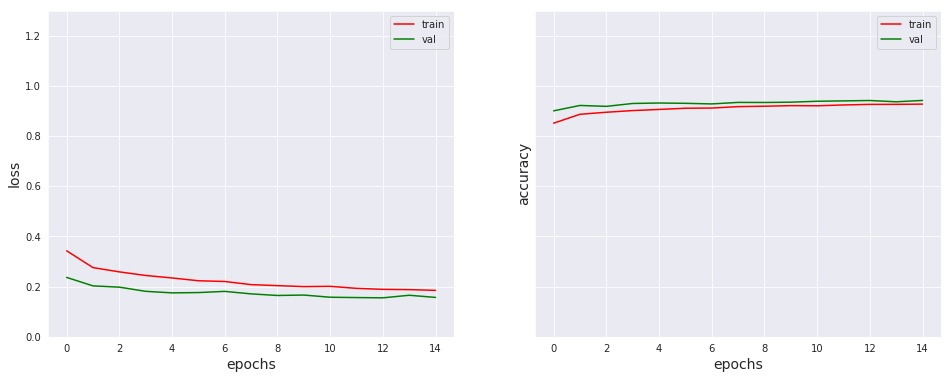

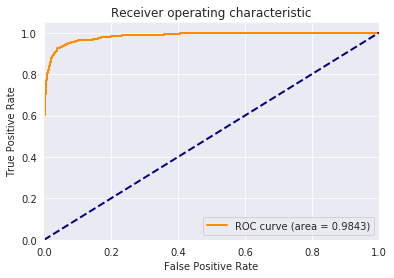

AUROC: 0.984261


In [21]:
model_ft_trained = train_model(model_ft, criterion, optimizer_ft, dataloaders, CHECKPOINT_PATH,
                               scheduler=None, num_epochs=15, is_inception=MODEL_NAME=='inception')

## 7. Test

### Test-time augmentation

Prediction accuracy can be further improved by Test Time Augmentation (TTA). The transformations at test time change the image such that the model has higher chances of capturing the desired shape and predicting accordingly.

In [22]:
tta_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.4),
        transforms.ColorJitter(contrast=0.4), 
        transforms.ColorJitter(saturation=0.4),
        transforms.ColorJitter(hue=0.4),
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0,0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]),
    ]),
    data_transforms['val']])

### Test helper functions

In [23]:
def predict(test_loader, model_pred):
    model_pred.eval()
    ids_all, predictions_all = [], []
    for index, batch in enumerate(test_loader):
        X = batch["image"]
        ids_all.extend(batch["id"])
        with torch.set_grad_enabled(False):
            y_pred = model_pred(X)
            # the second element of the one-hot vector contains
            # the score (probability-like) the image contains a tumor
            predictions_all.extend(torch.sigmoid(y_pred).detach().cpu().numpy()[:, 1])
    return ids_all, predictions_all

def get_tta_predictions(tta_transforms, test_paths):
    # Load the test data
    test_dataset = CancerDataset(num_classes = NUM_CLASSES,
                                 files_path = test_paths,
                                 transform = tta_transforms)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)

    # Load a new model and apply the trained weights
    trained_model = MODEL_FOR_PREDS
    trained_model.fc = nn.Linear(trained_model.fc.in_features, NUM_CLASSES)
    if MODEL_NAME == 'inception':
        trained_model.AuxLogits = models.inception.InceptionAux(768, NUM_CLASSES)

    trained_model = trained_model.cuda()
    trained_model = nn.DataParallel(trained_model)
    trained_model.load_state_dict(torch.load(CHECKPOINT_PATH)['model_state_dict'])

    tta_ids, tta_preds = predict(test_loader, trained_model)
    assert(len(tta_ids) == len(tta_preds))
    return tta_ids, tta_preds

### Run the test

Confusion matrix, without normalization
[[1859  111]
 [ 104 1236]]


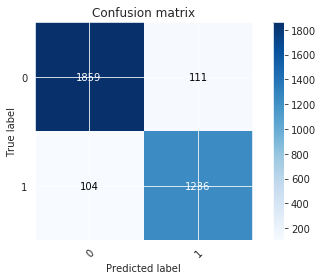

AUROC - mean: 0.9821, std: 0.0052
Accuracy - mean: 0.9350, std: 0.0137


In [24]:
local_test = StratifiedShuffleSplit(n_splits=10, test_size=0.1,
                                    random_state=np.random.RandomState(seed=42))

X_tests, y_tests = [], []

for _, test_index in local_test.split(split.X_test_paths, split.y_test):
    X_tests.append(split.X_test_paths[test_index])
    y_tests.append(split.y_test[test_index])

ids, predictions = [], []
aurocs, accuracy_scores = [], []

ys, predicted_ys = [], []

for _, (X_part, y_part) in enumerate(zip(X_tests, y_tests)):
    tta_ids, tta_preds = get_tta_predictions(tta_transforms, X_part)
    auroc_part = Plot.get_auroc(y_part, tta_preds, plot=False)
    ids.extend(tta_ids)
    predictions.extend(tta_preds)
    aurocs.append(auroc_part)

    binary_preds_part = (np.array(tta_preds) > 0.5).astype(int)
    ys.extend(y_part)
    predicted_ys.extend(binary_preds_part)
    accuracy_scores.append(accuracy_score(y_part, binary_preds_part))


Plot.plot_confusion_matrix(ys, predicted_ys, classes=[0, 1],
                           normalize=False, title='Confusion matrix')

print("AUROC - mean: {:.4f}, std: {:.4f}".format(np.mean(aurocs), np.std(aurocs)))
print("Accuracy - mean: {:.4f}, std: {:.4f}".format(np.mean(accuracy_scores), np.std(accuracy_scores)))

The accuracy score corresponds to the run on the 30% input data and when only 15 epochs of training were performed. This may be enough for experiments and further model tuning but the amount of input data and the traing time should be increased when doing final training.

## 8. Upload results to the project

To upload the checkpoint model weights and the log file from the local execution environment to the DNAnexus project, we can use `dx upload`, for example:

In [1]:
dxpy.upload(CHECKPOINT_PATH)
dxpy.upload(CHECKPOINT_PATH + ".log")
dx upload histopathology_resnet50_subset30pct_2019-05-17-17-51-18.pth
dx upload histopathology_resnet50_subset30pct_2019-05-17-17-51-18.pth.log

ID                  file-FYPPfK00VP65Z2y5888YpqFj
Class               file
Project             project-FVKzBg80VP61b0G5865BPV9j
Folder              /Notebooks
Name                histopathology_resnet50_subset30pct_2019-05-17-17-51-18.pt
                    h
State               closing
Visibility          visible
Types               -
Properties          -
Tags                -
Outgoing links      -
Created             Fri May 17 18:19:36 2019
Created by          azalcman
 via the job        job-FYPJz500VP6Kjg40KPJX3v2k
Last modified       Fri May 17 18:19:43 2019
Media type          
archivalState       "live"
ID                  file-FYPPfQ00VP6KYf18K01P58PP
Class               file
Project             project-FVKzBg80VP61b0G5865BPV9j
Folder              /Notebooks
Name                histopathology_resnet50_subset30pct_2019-05-17-17-51-18.pt
                    h.log
State               closing
Visibility          visible
Types               -
Properties          -
Tags            